In [1]:
import torch
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.modeling import build_model
from custom_anchorGen2 import CustomAnchorGenerator
from custom_backbone import CustomResNetBackbone
from CustomFastRCNNOutputLayers import CustomFastRCNNOutputLayers
from CustomStandardROIHeads import CustomStandardROIHeads

device = torch.device("cuda:1")
# Load Detectron2 default model config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) 
# Set device in config
cfg.MODEL.DEVICE = "cuda:1"  # Add this line
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.DATASETS.TRAIN = ("RADIal_COCO-style_train",)
cfg.DATASETS.TEST = ("RADIal_COCO-style_val",)

# Manually set the required fields for a ResNet-FPN backbone:
cfg.MODEL.RESNETS.DEPTH = 50  # or 101, depending on your design
cfg.MODEL.RESNETS.STEM_OUT_CHANNELS = 192
cfg.MODEL.RESNETS.OUT_FEATURES = ["res2", "res3", "res4"] 
cfg.MODEL.RESNETS.NORM = ""
cfg.MODEL.FPN.IN_FEATURES = ["res2", "res3", "res4"]

# Update anchor generator config

cfg.MODEL.ANCHOR_GENERATOR.STRIDES = [1, 2, 4]
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[71], [71], [71]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.078125]]
cfg.MODEL.ANCHOR_GENERATOR.OFFSET = 0.5
cfg.MODEL.ANCHOR_GENERATOR.STD_BEHAVIOR = True

# Use your custom ROI heads that instantiate the custom box predictor
cfg.MODEL.ROI_HEADS.NAME = "CustomStandardROIHeads"

# Update box regression weights to include the extra aperture output:
# The tuple now has 5 values (dx, dy, dw, dh, aperture)
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS = (1.0, 5.0, 1.0, 5.0)

# Set the box regression loss type and weight.
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_TYPE = "smooth_l1"
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_WEIGHT = 1.0

# Set aperture-specific loss weight (this is used by your custom predictor)
cfg.MODEL.ROI_BOX_HEAD.APERTURE_LOSS_WEIGHT = 5.0

# If you want a class-agnostic prediction for the box (and thus aperture) regressions:
cfg.MODEL.ROI_BOX_HEAD.CLS_AGNOSTIC_BBOX_REG = True

cfg.MODEL.ROI_HEADS.IN_FEATURES = ["p2", "p3", "p4"]
cfg.MODEL.RPN.IN_FEATURES = ["p2", "p3", "p4"]
cfg.MODEL.FPN.OUT_CHANNELS = 256
cfg.MODEL.FPN.NORM = ""
cfg.MODEL.FPN.FUSE_TYPE = "sum"
cfg.MODEL.BACKBONE.FREEZE_AT = 0
# Set the backbone
cfg.MODEL.BACKBONE.NAME = 'CustomResNetBackbone'
cfg.MODEL.PIXEL_MEAN = [-2.6244e-03, -2.1335e-01,  1.8789e-02, -1.4427e+00, -3.7618e-01,
                1.3594e+00, -2.2987e-01,  1.2244e-01,  1.7359e+00, -6.5345e-01,
                3.7976e-01,  5.5521e+00,  7.7462e-01, -1.5589e+00, -7.2473e-01,
                1.5182e+00, -3.7189e-01, -8.8332e-02, -1.6194e-01,  1.0984e+00,
                9.9929e-01, -1.0495e+00,  1.9972e+00,  9.2869e-01,  1.8991e+00,
               -2.3772e-01,  2.0000e+00,  7.7737e-01,  1.3239e+00,  1.1817e+00,
               -6.9696e-01,  4.4288e-01] 
cfg.MODEL.PIXEL_STD = [20775.3809, 23085.5000, 23017.6387, 14548.6357, 32133.5547, 28838.8047,
                27195.8945, 33103.7148, 32181.5273, 35022.1797, 31259.1895, 36684.6133,
                33552.9258, 25958.7539, 29532.6230, 32646.8984, 20728.3320, 23160.8828,
                23069.0449, 14915.9053, 32149.6172, 28958.5840, 27210.8652, 33005.6602,
                31905.9336, 35124.9180, 31258.4316, 31086.0273, 33628.5352, 25950.2363,
                29445.2598, 32885.7422]
cfg.MODEL.ANCHOR_GENERATOR.NAME = 'CustomAnchorGenerator'

In [41]:
from detectron2.data.datasets import load_coco_json
from detectron2.data import DatasetCatalog, MetadataCatalog

train_json_file = "/home/eorozco/projects/radarObjDet/cocoRadialTrain.json"
image_root = "/volumes/8TB_volume1/eorozco/RADIal/RADIal/radar_FFT"
train_dataset_name = "RADIal_COCO-style_train"

DatasetCatalog.register(
    train_dataset_name,
    lambda: load_coco_json(
        json_file=train_json_file,
        image_root=image_root,
        dataset_name=train_dataset_name,
        extra_annotation_keys=["aperture"]
    )
)
MetadataCatalog.get(train_dataset_name).set(thing_classes=["car"])

val_json_file = "/home/eorozco/projects/radarObjDet/cocoRadialVal.json"
val_dataset_name = "RADIal_COCO-style_val"
DatasetCatalog.register(
    val_dataset_name,
    lambda: load_coco_json(
        json_file=val_json_file,
        image_root=image_root,
        dataset_name=val_dataset_name,
        extra_annotation_keys=["aperture"]
    )
)
MetadataCatalog.get(val_dataset_name).set(thing_classes=["car"])

# Retrieve the dataset dictionaries
dataset_dicts = DatasetCatalog.get("RADIal_COCO-style_train")

AssertionError: Dataset 'RADIal_COCO-style_train' is already registered!

In [38]:
import copy
import numpy as np
import torch
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.structures import BoxMode, Instances

# You can pass your config (cfg) into the mapper if needed. Here I assume that PIXEL_MEAN
# and PIXEL_STD are available (they should be lists of 32 values in your case).
# Alternatively, you can hard-code them or load them from cfg.MODEL.PIXEL_MEAN and cfg.MODEL.PIXEL_STD.
PIXEL_MEAN = torch.tensor([-0.0026244, -0.21335,  0.018789, -1.4427, -0.37618, 1.3594,
                           -0.22987,  0.12244,  1.7359, -0.65345,  0.37976, 5.5521,
                            0.77462, -1.5589, -0.72473, 1.5182, -0.37189, -0.088332,
                           -0.16194, 1.0984,  0.99929, -1.0495,  1.9972,  0.92869,
                            1.8991, -0.23772,  2.0,  0.77737, 1.3239,  1.1817,
                           -0.69696,  0.44288], dtype=torch.float32)

PIXEL_STD = torch.tensor([20775.3809, 23085.5, 23017.6387, 14548.6357, 32133.5547, 28838.8047,
                          27195.8945, 33103.7148, 32181.5273, 35022.1797, 31259.1895, 36684.6133,
                          33552.9258, 25958.7539, 29532.623, 32646.8984, 20728.332, 23160.8828,
                          23069.0449, 14915.9053, 32149.6172, 28958.584, 27210.8652, 33005.6602,
                          31905.9336, 35124.918, 31258.4316, 31086.0273, 33628.5352, 25950.2363,
                          29445.2598, 32885.7422], dtype=torch.float32)


def radar_mapper(dataset_dict):
    """
    A custom dataset mapper for radar data stored in .npy files.
    
    It performs the following:
      1. Deep-copies the dict.
      2. Loads the radar data from the given file.
      3. Concatenates the real and imaginary parts along the channel dimension.
      4. Converts the resulting array to a tensor and permutes to channel-first.
      5. Normalizes the tensor using the provided PIXEL_MEAN and PIXEL_STD.
      6. Processes the annotations: copies the "aperture" field to "gt_aperture",
         transforms the annotations (with no geometric transforms), and converts them to
         an Instances object, adding the extra field.
    """
    dataset_dict = copy.deepcopy(dataset_dict)

    # Load radar data from the .npy file.
    radar = np.load(dataset_dict["file_name"], allow_pickle=True)
    
    # Concatenate the real and imaginary parts along the channel axis.
    # (Assumes the .npy file has a complex array where real and imag parts are available.)
    radar = np.concatenate([radar.real, radar.imag], axis=2)  # Now shape: (H, W, C)
    
    # Convert the numpy array to a torch tensor and permute to (C, H, W)
    radar = torch.as_tensor(radar.astype("float32")).permute(2, 0, 1)
    
    # Normalize using the provided pixel mean and std.
    radar = (radar - PIXEL_MEAN[:, None, None]) / PIXEL_STD[:, None, None]
    
    dataset_dict["image"] = radar

    if "annotations" in dataset_dict:
        annos = dataset_dict.pop("annotations")
        # Copy the extra "aperture" field into a new key "gt_aperture" for each annotation.
        for anno in annos:
            if "aperture" in anno:
                anno["gt_aperture"] = anno["aperture"]
        
        # Here, we do not apply any geometric transforms (empty list).
        annos = [utils.transform_instance_annotations(annotation, [], radar.shape[1:]) 
                 for annotation in annos]
        
        # Convert annotations to an Instances object.
        instances = utils.annotations_to_instances(annos, radar.shape[1:])
        
        # Manually add the aperture values to the Instances object.
        # Note: The default annotations_to_instances does not handle "gt_aperture"
        # so we add it here as a tensor with shape (num_instances, 1).
        gt_apertures = [anno.get("gt_aperture") for anno in annos]
        if len(gt_apertures) > 0:
            instances.gt_aperture = torch.tensor(gt_apertures, dtype=torch.float32).unsqueeze(1)
        
        dataset_dict["instances"] = instances

    return dataset_dict


In [39]:
import torch
from detectron2.data import build_detection_train_loader
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
from detectron2.config import get_cfg


# Build the train dataloader using your custom mapper.
train_loader = build_detection_train_loader(cfg, mapper=radar_mapper)

# Retrieve one batch from the train loader.
data_batch = next(iter(train_loader))
print("A batch from the train loader:")
print("Keys in batch sample:", data_batch[0].keys())
print("Image shape:", data_batch[0]["image"].shape)
if "instances" in data_batch[0]:
    print("Instances fields:", data_batch[0]["instances"].get_fields().keys())

# Build the model.
model = build_model(cfg)
model = model.to("cuda:1")  # or whichever device you are using
model.train()  # Set model to training mode

# Wrap the forward pass within an EventStorage context.
with EventStorage():
    losses = model(data_batch)
    total_loss = sum(losses.values())
    print("Losses:", {k: v.item() for k, v in losses.items()})
    print("Total loss:", total_loss.item())
    total_loss.backward()
    print("Backward pass successful!")

# Optionally, check gradient norms of a parameter that contributes to aperture prediction.
# For example, if your custom predictor's bbox_pred layer is responsible:
for name, param in model.named_parameters():
    if "bbox_pred" in name:
        grad_norm = param.grad.norm().item() if param.grad is not None else 0.0
        print(f"Gradient norm for {name}: {grad_norm}")

The following dataset names are not registered in the DatasetCatalog: {'RADIal_COCO-style_train'}. Available datasets are KeysView(DatasetCatalog(registered datasets: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0

KeyError: "Dataset 'RADIal_COCO-style_train' is not registered! Available datasets are: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_seg_train, cityscapes_fine_instance_seg_val, cityscapes_fine_sem_seg_val, cityscapes_fine_instance_seg_test, cityscapes_fine_sem_seg_test, cityscapes_fine_panoptic_train, cityscapes_fine_panoptic_val, voc_2007_trainval, voc_2007_train, voc_2007_val, voc_2007_test, voc_2012_trainval, voc_2012_train, voc_2012_val, ade20k_sem_seg_train, ade20k_sem_seg_val"

# Set config

In [1]:
import torch
import numpy as np
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.modeling import build_model
from custom_anchorGen2 import CustomAnchorGenerator
from custom_backbone import CustomResNetBackbone
from CustomFastRCNNOutputLayers import CustomFastRCNNOutputLayers
from CustomStandardROIHeads import CustomStandardROIHeads
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

device = torch.device("cuda:1")
# Load Detectron2 default model config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) 
# Set device in config
cfg.MODEL.WEIGHTS = ""
cfg.MODEL.DEVICE = "cuda:1"  # Add this line
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.DATASETS.TRAIN = ("RADIal_COCO-style_train",)
cfg.DATASETS.TEST = ("RADIal_COCO-style_val",)

# Manually set the required fields for a ResNet-FPN backbone:
cfg.MODEL.RESNETS.DEPTH = 50  # or 101, depending on your design
cfg.MODEL.RESNETS.STEM_OUT_CHANNELS = 192
#cfg.MODEL.RESNETS.OUT_FEATURES = ["res2", "res3", "res4"] 
cfg.MODEL.RESNETS.OUT_FEATURES = ["res2", "res3", "res4", "res5"] 
cfg.MODEL.RESNETS.NORM = ""
#cfg.MODEL.FPN.IN_FEATURES = ["res2", "res3", "res4"]
cfg.MODEL.FPN.IN_FEATURES = ["res2", "res3", "res4", "res5"]

# Update anchor generator config

cfg.MODEL.ANCHOR_GENERATOR.STRIDES = [1, 2, 4, 8]
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[71], [71], [71], [71]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.078125]]
cfg.MODEL.ANCHOR_GENERATOR.OFFSET = 0.5
cfg.MODEL.ANCHOR_GENERATOR.STD_BEHAVIOR = True

# Use your custom ROI heads that instantiate the custom box predictor
cfg.MODEL.ROI_HEADS.NAME = "CustomStandardROIHeads"

# Update box regression weights to include the extra aperture output:
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS = (1.0, 5.0, 1.0, 5.0)
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_TYPE = "smooth_l1"
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_WEIGHT = 1.0
cfg.MODEL.ROI_BOX_HEAD.APERTURE_LOSS_WEIGHT = 20
cfg.MODEL.ROI_BOX_HEAD.LOSS_CLS_WEIGHT=2
cfg.MODEL.ROI_BOX_HEAD.CLS_AGNOSTIC_BBOX_REG = True

cfg.MODEL.ROI_HEADS.IN_FEATURES = ["p0", "p1", "p2", "p3"]
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.35
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST=0.3
cfg.MODEL.RPN.IN_FEATURES = ["p0", "p1", "p2", "p3"]
cfg.MODEL.FPN.OUT_CHANNELS = 256
cfg.MODEL.FPN.NORM = ""
cfg.MODEL.FPN.FUSE_TYPE = "sum"
cfg.MODEL.BACKBONE.FREEZE_AT = 0
# Set the backbone
cfg.MODEL.BACKBONE.NAME = 'CustomResNetBackbone'
""" cfg.MODEL.PIXEL_MEAN = [-2.6244e-03, -2.1335e-01,  1.8789e-02, -1.4427e+00, -3.7618e-01,
                1.3594e+00, -2.2987e-01,  1.2244e-01,  1.7359e+00, -6.5345e-01,
                3.7976e-01,  5.5521e+00,  7.7462e-01, -1.5589e+00, -7.2473e-01,
                1.5182e+00, -3.7189e-01, -8.8332e-02, -1.6194e-01,  1.0984e+00,
                9.9929e-01, -1.0495e+00,  1.9972e+00,  9.2869e-01,  1.8991e+00,
               -2.3772e-01,  2.0000e+00,  7.7737e-01,  1.3239e+00,  1.1817e+00,
               -6.9696e-01,  4.4288e-01]  """
""" cfg.MODEL.PIXEL_STD = [20775.3809, 23085.5000, 23017.6387, 14548.6357, 32133.5547, 28838.8047,
                27195.8945, 33103.7148, 32181.5273, 35022.1797, 31259.1895, 36684.6133,
                33552.9258, 25958.7539, 29532.6230, 32646.8984, 20728.3320, 23160.8828,
                23069.0449, 14915.9053, 32149.6172, 28958.5840, 27210.8652, 33005.6602,
                31905.9336, 35124.9180, 31258.4316, 31086.0273, 33628.5352, 25950.2363,
                29445.2598, 32885.7422] """
cfg.MODEL.ANCHOR_GENERATOR.NAME = 'CustomAnchorGenerator'
model = build_model(cfg)
model

# Build the model.
#model = build_model(cfg)
#model = model.to("cuda:1")  # or whichever device you are using
#DetectionCheckpointer(model).load("/home/eorozco/projects/radarObjDet/radarDetector/output1/model_final.pth")

GeneralizedRCNN(
  (backbone): CustomResNetBackbone(
    (backbone): FPN(
      (fpn_lateral0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fpn_lateral1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fpn_lateral2): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fpn_lateral3): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bottom_up): CustomBackboneWrapper(
        (backbone): ResNet(
          (stem): MIMOStem(
            (conv): Conv2d(192, 192, kernel_size=(3, 12), stride=(1, 1), padding=(1, 0), dilation=(1, 16), bias=False)
            (bn): BatchNorm2d(192, eps=1e-05, momentum=

# Register dataset

In [2]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader, build_detection_test_loader
from detectron2.data.datasets import load_coco_json
train_json = "/home/eorozco/projects/radarObjDet/cocoRadialTrain.json"
val_json = "/home/eorozco/projects/radarObjDet/cocoRadialVal.json"
image_root = "/volumes/8TB_volume1/eorozco/RADIal/RADIal/radar_FFT"
train_name = "RADIal_COCO-style_train"
val_name = "RADIal_COCO-style_val"

DatasetCatalog.register(
    train_name,
    lambda: load_coco_json(
        json_file=train_json,
        image_root=image_root,
        dataset_name=train_name,
        extra_annotation_keys=["aperture"]
    )
)
MetadataCatalog.get(train_name).set(thing_classes=["car"], evaluator_type="coco")

DatasetCatalog.register(
    val_name,
    lambda: load_coco_json(
        json_file=val_json,
        image_root=image_root,
        dataset_name=val_name,
        extra_annotation_keys=["aperture"]
    )
)
MetadataCatalog.get(val_name).set(thing_classes=["car"], evaluator_type="coco")

namespace(name='RADIal_COCO-style_val',
          thing_classes=['car'],
          evaluator_type='coco')

# Mapper

In [3]:
import copy
import numpy as np
import torch
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.structures import BoxMode, Instances

# You can pass your config (cfg) into the mapper if needed. Here I assume that PIXEL_MEAN
# and PIXEL_STD are available (they should be lists of 32 values in your case).
# Alternatively, you can hard-code them or load them from cfg.MODEL.PIXEL_MEAN and cfg.MODEL.PIXEL_STD.
PIXEL_MEAN = torch.tensor([-0.0026244, -0.21335,  0.018789, -1.4427, -0.37618, 1.3594,
                           -0.22987,  0.12244,  1.7359, -0.65345,  0.37976, 5.5521,
                            0.77462, -1.5589, -0.72473, 1.5182, -0.37189, -0.088332,
                           -0.16194, 1.0984,  0.99929, -1.0495,  1.9972,  0.92869,
                            1.8991, -0.23772,  2.0,  0.77737, 1.3239,  1.1817,
                           -0.69696,  0.44288], dtype=torch.float32)

PIXEL_STD = torch.tensor([20775.3809, 23085.5, 23017.6387, 14548.6357, 32133.5547, 28838.8047,
                          27195.8945, 33103.7148, 32181.5273, 35022.1797, 31259.1895, 36684.6133,
                          33552.9258, 25958.7539, 29532.623, 32646.8984, 20728.332, 23160.8828,
                          23069.0449, 14915.9053, 32149.6172, 28958.584, 27210.8652, 33005.6602,
                          31905.9336, 35124.918, 31258.4316, 31086.0273, 33628.5352, 25950.2363,
                          29445.2598, 32885.7422], dtype=torch.float32)


def radar_mapper(dataset_dict):
    """
    A custom dataset mapper for radar data stored in .npy files.
    
    It performs the following:
      1. Deep-copies the dict.
      2. Loads the radar data from the given file.
      3. Concatenates the real and imaginary parts along the channel dimension.
      4. Converts the resulting array to a tensor and permutes to channel-first.
      5. Normalizes the tensor using the provided PIXEL_MEAN and PIXEL_STD.
      6. Processes the annotations: copies the "aperture" field to "gt_aperture",
         transforms the annotations (with no geometric transforms), and converts them to
         an Instances object, adding the extra field.
    """
    dataset_dict = copy.deepcopy(dataset_dict)
    
    # Load radar data from the .npy file.
    radar = np.load(dataset_dict["file_name"], allow_pickle=True)
    
    # Concatenate the real and imaginary parts along the channel axis.
    # (Assumes the .npy file has a complex array where real and imag parts are available.)
    radar = np.concatenate([radar.real, radar.imag], axis=2)  # Now shape: (H, W, C)
    
    # Convert the numpy array to a torch tensor and permute to (C, H, W)
    radar = torch.as_tensor(radar.astype("float32")).permute(2, 0, 1)
    
    # Normalize using the provided pixel mean and std.
    radar = (radar - PIXEL_MEAN[:, None, None]) / PIXEL_STD[:, None, None]
    
    dataset_dict["image"] = radar

    if "annotations" in dataset_dict:
        annos = dataset_dict.pop("annotations")
        # Copy the extra "aperture" field into a new key "gt_aperture" for each annotation.
        for anno in annos:
            if "aperture" in anno:
                anno["gt_aperture"] = anno["aperture"]
        
        # Here, we do not apply any geometric transforms (empty list).
        annos = [utils.transform_instance_annotations(annotation, [], radar.shape[1:]) 
                 for annotation in annos]
        
        # Convert annotations to an Instances object.
        instances = utils.annotations_to_instances(annos, radar.shape[1:])
        
        # Manually add the aperture values to the Instances object.
        # Note: The default annotations_to_instances does not handle "gt_aperture"
        # so we add it here as a tensor with shape (num_instances, 1).
        gt_apertures = [anno.get("gt_aperture") for anno in annos]
        if len(gt_apertures) > 0:
            instances.gt_aperture = torch.tensor(gt_apertures, dtype=torch.float32).unsqueeze(1)
        
        dataset_dict["instances"] = instances

    return dataset_dict


# Build data loader and model

In [4]:
import torch
from detectron2.data import build_detection_train_loader, build_detection_test_loader
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
from detectron2.config import get_cfg


# Build the train dataloader using your custom mapper.
train_loader = build_detection_train_loader(cfg, mapper=radar_mapper)
# Retrieve one batch from the train loader.
data_batch = next(iter(train_loader))

# Build the model.
model = build_model(cfg)
model = model.to("cuda:1")  # or whichever device you are using
#DetectionCheckpointer(model).load("/home/eorozco/projects/radarObjDet/radarDetector/output/model_0009999.pth")

In [7]:
print(model.backbone)

CustomResNetBackbone(
  (backbone): FPN(
    (fpn_lateral0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral2): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bottom_up): CustomBackboneWrapper(
      (backbone): ResNet(
        (stem): MIMOStem(
          (conv): Conv2d(32, 192, kernel_size=(3, 12), stride=(1, 1), padding=(1, 0), dilation=(1, 16), bias=False)
          (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      

In [5]:
model

GeneralizedRCNN(
  (backbone): CustomResNetBackbone(
    (backbone): FPN(
      (fpn_lateral0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fpn_lateral1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fpn_lateral2): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fpn_lateral3): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bottom_up): CustomBackboneWrapper(
        (backbone): ResNet(
          (stem): MIMOStem(
            (conv): Conv2d(32, 192, kernel_size=(3, 12), stride=(1, 1), padding=(1, 0), dilation=(1, 16), bias=False)
            (bn): BatchNorm2d(192, eps=1e-05, momentum=0

In [5]:
import torch
from detectron2.data import build_detection_train_loader, build_detection_test_loader

test_data_loader = build_detection_test_loader(cfg, "RADIal_COCO-style_val", mapper=radar_mapper)
test_data_batch = next(iter(test_data_loader))

In [18]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from CustomMatchingEvaluator import CustomMatchingEvaluator

evaluator = CustomMatchingEvaluator(iou_threshold=0.10)
eval_results= inference_on_dataset(model, test_data_loader, evaluator)
det_metrics_train = eval_results.get('detection_metrics', {})
aper_metrics_train = eval_results.get('aperture_evaluation', {})
precision_train = det_metrics_train.get('precision', 0)
recall_train = det_metrics_train.get('recall', 0)
mean_abs_error_train = aper_metrics_train.get('mean_absolute_error', 0)
num_matches_train = aper_metrics_train.get('num_matches', 0)
tp_train = det_metrics_train.get('true_positives', 0)
fp_train = det_metrics_train.get('false_positives', 0)
fn_train = det_metrics_train.get('false_negatives', 0)
if (precision_train + recall_train) > 0:
    f1_train = 2 * precision_train * recall_train / (precision_train + recall_train)
else:
    f1_train = 0.0
print(f"f1: {f1_train}")

f1: 0.9345794392523366


In [22]:
eval_results

{'aperture_evaluation': {'mean_absolute_error': 0.9976095863751002,
  'num_matches': 700},
 'detection_metrics': {'true_positives': 700,
  'false_positives': 41,
  'false_negatives': 57,
  'precision': 0.9446693657219973,
  'recall': 0.9247027741083224}}

In [8]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total parameters:", total_params)
print("Trainable parameters:", trainable_params)

Total parameters: 25489804
Trainable parameters: 25489804


In [10]:
from detectron2.utils.analysis import parameter_count

count_dict = parameter_count(model)
print("Parameter counts:", count_dict)

Parameter counts: defaultdict(<class 'int'>, {'': 15625612, 'backbone': 1131392, 'backbone.backbone': 1131392, 'backbone.backbone.fpn_lateral0': 65792, 'backbone.backbone.fpn_lateral0.weight': 65536, 'backbone.backbone.fpn_lateral0.bias': 256, 'backbone.backbone.fpn_output0': 590080, 'backbone.backbone.fpn_output0.weight': 589824, 'backbone.backbone.fpn_output0.bias': 256, 'backbone.backbone.bottom_up': 475520, 'backbone.backbone.bottom_up.backbone': 475520, 'backbone.backbone.bottom_up.backbone.stem': 221568, 'backbone.backbone.bottom_up.backbone.stem.conv': 221184, 'backbone.backbone.bottom_up.backbone.stem.conv.weight': 221184, 'backbone.backbone.bottom_up.backbone.stem.bn': 384, 'backbone.backbone.bottom_up.backbone.stem.bn.weight': 192, 'backbone.backbone.bottom_up.backbone.stem.bn.bias': 192, 'backbone.backbone.bottom_up.backbone.res2': 253952, 'backbone.backbone.bottom_up.backbone.res2.0': 114688, 'backbone.backbone.bottom_up.backbone.res2.0.shortcut': 49152, 'backbone.backbone.

In [7]:
output_dir = "/home/eorozco/projects/radarObjDet/radarDetector/output1"
model.eval()
with torch.no_grad():
    outputs = model(test_data_batch)



/home/eorozco/miniconda3/envs/radarTron/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789116784/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
from CustomMatchingEvaluator import CustomMatchingEvaluator

# Create evaluator with desired IoU threshold
evaluator = CustomMatchingEvaluator(iou_threshold=0.5)
evaluator.reset()
evaluator.process(test_data_batch, outputs)
match_results = evaluator.evaluate()
print("Matching results per image:", match_results)

Matching results per image: {1: [], 'aperture_evaluation': {'mean_absolute_error': nan, 'num_matches': 0}, 'detection_metrics': {'true_positives': 0, 'false_positives': 0, 'false_negatives': 1, 'precision': 0.0, 'recall': 0.0}}


In [ ]:
from COCOEvalRadar import CustomCOCOEvaluator
# Create an instance of the evaluator. In manual mode set distributed=False.
evaluator = CustomCOCOEvaluator("RADIal_COCO-style_train", output_dir=output_dir, distributed=False)
evaluator.reset()

evaluator.process([data_batch[5]], outputs)
eval_results = evaluator.evaluate()
print("Evaluation results:", eval_results)

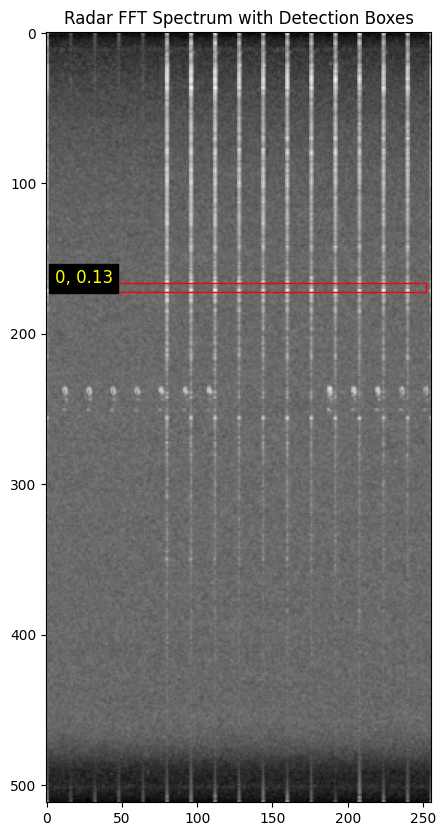

In [8]:
file_path="/volumes/8TB_volume1/eorozco/RADIal/RADIal/radar_FFT/fft_003633.npy"
PIXEL_MEAN = torch.tensor([-0.0026244, -0.21335,  0.018789, -1.4427, -0.37618, 1.3594,
                           -0.22987,  0.12244,  1.7359, -0.65345,  0.37976, 5.5521,
                            0.77462, -1.5589, -0.72473, 1.5182, -0.37189, -0.088332,
                           -0.16194, 1.0984,  0.99929, -1.0495,  1.9972,  0.92869,
                            1.8991, -0.23772,  2.0,  0.77737, 1.3239,  1.1817,
                           -0.69696,  0.44288], dtype=torch.float32)

PIXEL_STD = torch.tensor([20775.3809, 23085.5, 23017.6387, 14548.6357, 32133.5547, 28838.8047,
                          27195.8945, 33103.7148, 32181.5273, 35022.1797, 31259.1895, 36684.6133,
                          33552.9258, 25958.7539, 29532.623, 32646.8984, 20728.332, 23160.8828,
                          23069.0449, 14915.9053, 32149.6172, 28958.584, 27210.8652, 33005.6602,
                          31905.9336, 35124.918, 31258.4316, 31086.0273, 33628.5352, 25950.2363,
                          29445.2598, 32885.7422], dtype=torch.float32)

radarInput = np.load(file_path, allow_pickle=True)
    
# Concatenate the real and imaginary parts along the channel axis.
# (Assumes the .npy file has a complex array where real and imag parts are available.)
radarInput = np.concatenate([radarInput.real, radarInput.imag], axis=2)  # Now shape: (H, W, C)

# Convert the numpy array to a torch tensor and permute to (C, H, W)
radarInput = torch.as_tensor(radarInput.astype("float32")).permute(2, 0, 1)

# Normalize using the provided pixel mean and std.
radarInput = (radarInput - PIXEL_MEAN[:, None, None]) / PIXEL_STD[:, None, None]

# Suppose radarInput has shape [32, 512, 256] -> [C, H, W]
batched_inputs = [{"image": radarInput}]

model.eval()
with torch.no_grad():
  outputs = model(batched_inputs)

  import numpy as np

output_filename = "detections.txt"
with open(output_filename, "w") as f:
    # Loop over each image's detections.
    for output in outputs:
        instances = output["instances"]
        boxes = instances.pred_boxes.tensor.cpu().numpy()  # shape (N, 4)
        scores = instances.scores.cpu().numpy()            # shape (N,)
        classes = instances.pred_classes.cpu().numpy()       # shape (N,)
        # Check for your custom aperture field
        if hasattr(instances, "aperture"):
            # Ensure the aperture tensor is a 2D array of shape (N, ?)
            aperture = instances.aperture.cpu().numpy()
        else:
            aperture = None

        # Iterate over each detection and write a line with: class, score, boxes, aperture
        for i in range(boxes.shape[0]):
            cls_val = classes[i]
            score_val = scores[i]
            box_val = boxes[i]  # [x0, y0, x1, y1]
            # If aperture is available, extract its value.
            if aperture is not None:
                # If aperture has extra dimensions, take the first element.
                ap_val = ((aperture[i][0] if aperture[i].ndim > 0 else aperture[i])*80)-40
            else:
                ap_val = "N/A"
            # Calculate the normalized center y-coordinate
            y0 = box_val[1]
            y1 = box_val[3]
            center_y = ((((y1 - y0) / 2) + y0)*103)/512

            # Format the bounding box and insert center_y
            bbox_str = f"[{box_val[0]}, {box_val[1]}, {box_val[2]}, {box_val[3]}]"
            line = f"{cls_val}, {score_val:.4f}, {bbox_str}, {center_y:.4f}, {ap_val}\n"
            f.write(line)


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set print options
np.set_printoptions(suppress=True)

# Load your radar FFT data
radarInput = np.load(file_path, allow_pickle=True)
# Combine real and imaginary parts along the third axis
radarInput = np.concatenate([radarInput.real, radarInput.imag], axis=2)

# Reconstruct the FFT plot and compute the power spectrum
radar_FFT_plot = radarInput[..., ::2] + 1j * radarInput[..., 1::2]
power_spectrum = np.sum(np.abs(radar_FFT_plot), axis=2)
base_image = np.log(power_spectrum)

# Define your desired confidence threshold
conf_th = 0.05

# Read the detections from file and parse the first 2 entries that meet the threshold
detections = []
with open("detections.txt", "r") as f:
    for line in f:
        # Split the line by comma and remove extra spaces
        parts = [p.strip() for p in line.strip().split(',')]
        if len(parts) < 7:
            print("Skipping line due to unexpected format:", line)
            continue
        try:
            cls_val = parts[0]
            score_val = float(parts[1])
            # Check the confidence threshold
            if score_val <= conf_th:
                continue

            # The bounding box is spread over parts[2] to parts[5]
            x0 = float(parts[2].lstrip('['))
            y0 = float(parts[3])
            x1 = float(parts[4])
            y1 = float(parts[5].rstrip(']'))
        except Exception as e:
            print("Error parsing box from parts:", parts[2:6])
            continue
        
        detections.append((cls_val, score_val, [x0, y0, x1, y1]))
        # Stop after adding 2 valid detections
        if len(detections) >= 10:
            break

# Plot the base image
plt.figure(figsize=(14, 10))
plt.imshow(base_image, cmap="gray")  # using grayscale for clarity

# Get the current axes for adding rectangles
ax = plt.gca()

# Overlay the first 5 detection boxes
for cls_val, score_val, box_val in detections:
    x0, y0, x1, y1 = box_val
    width = x1 - x0
    height = y1 - y0
    rect = patches.Rectangle((x0, y0), width, height, linewidth=1,
                             edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    # Optionally, add a text label for each detection
    ax.text(x0, y0, f"{cls_val}, {score_val:.2f}", color='yellow',
            fontsize=12, backgroundcolor='black')

plt.title("Radar FFT Spectrum with Detection Boxes")
plt.show()

In [7]:
model

GeneralizedRCNN(
  (backbone): CustomResNetBackbone(
    (backbone): FPN(
      (fpn_lateral0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bottom_up): CustomBackboneWrapper(
        (backbone): ResNet(
          (stem): MIMOStem(
            (conv): Conv2d(32, 192, kernel_size=(3, 12), stride=(1, 1), padding=(1, 0), dilation=(1, 16), bias=False)
            (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (res2): Sequential(
            (0): BottleneckBlock(
              (shortcut): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (conv1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         

In [19]:
batched_inputs[0]['image'].shape

torch.Size([32, 512, 256])

# check parameters from backbone, RPN, ROI

In [41]:
from detectron2.utils.analysis import flop_count_operators

flops = flop_count_operators(model, (batched_inputs,))
print("FLOPs (conv): {:.2e}".format(flops.get('conv', 0)))
print("FLOPs (batch_norm): {:.2e}".format(flops.get('batch_norm', 0)))
print("FLOPs (linear): {:.2e}".format(flops.get('linear', 0)))

Unsupported operator prim::CallFunction encountered 8 time(s)
Unsupported operator aten::pad encountered 1 time(s)
Unsupported operator aten::topk encountered 1 time(s)
Unsupported operator torchvision::roi_align encountered 1 time(s)


FLOPs (conv): 2.27e+02
FLOPs (batch_norm): 5.03e-02
FLOPs (linear): 7.01e+00


In [47]:
from fvcore.nn import FlopCountAnalysis
from detectron2.modeling import ShapeSpec

dummy_input = torch.randn(1, 32, 512, 256).to(device)
input_shape = ShapeSpec(channels=32, height=512, width=256)

# Build your backbone
backbone = CustomResNetBackbone(cfg, input_shape=input_shape).to(device)

# Run FlopCountAnalysis
flops = FlopCountAnalysis(backbone, dummy_input)
print("Backbone FLOPs:", flops.total())
print("Backbone FLOPs by module:", flops.by_module())

Unsupported operator aten::add encountered 1 time(s)
Unsupported operator aten::add_ encountered 4 time(s)


Backbone FLOPs: 150114140160
Backbone FLOPs by module: Counter({'': 150114140160, 'backbone': 150114140160, 'backbone.fpn_output0': 77309411328, 'backbone.bottom_up': 64214794240, 'backbone.bottom_up.backbone': 64214794240, 'backbone.bottom_up.backbone.res2': 33285996544, 'backbone.bottom_up.backbone.stem': 30928797696, 'backbone.bottom_up.backbone.stem.conv': 30802968576, 'backbone.bottom_up.backbone.res2.0': 15032385536, 'backbone.bottom_up.backbone.res2.1': 9126805504, 'backbone.bottom_up.backbone.res2.2': 9126805504, 'backbone.fpn_lateral0': 8589934592, 'backbone.bottom_up.backbone.res2.0.shortcut': 6442450944, 'backbone.bottom_up.backbone.res2.0.conv2': 4831838208, 'backbone.bottom_up.backbone.res2.1.conv2': 4831838208, 'backbone.bottom_up.backbone.res2.2.conv2': 4831838208, 'backbone.bottom_up.backbone.res2.0.conv3': 2147483648, 'backbone.bottom_up.backbone.res2.1.conv1': 2147483648, 'backbone.bottom_up.backbone.res2.1.conv3': 2147483648, 'backbone.bottom_up.backbone.res2.2.conv1

In [48]:
from fvcore.nn import FlopCountAnalysis

dummy_feature = torch.randn(1, 256, 512, 256).to(device)  # adjust shape to match your FPN output
rpn_head = model.proposal_generator.rpn_head

flops_rpn_head = FlopCountAnalysis(rpn_head, (dummy_feature,))
print("RPN Head FLOPs:", flops_rpn_head.total())
print("RPN Head FLOPs by module:", flops_rpn_head.by_module())

RPN Head FLOPs: 77477183488
RPN Head FLOPs by module: Counter({'': 77477183488, 'conv': 77309411328, 'anchor_deltas': 134217728, 'objectness_logits': 33554432, 'conv.activation': 0})


In [ ]:
from fvcore.nn import FlopCountAnalysis

# The input to the box head is typically a pooled feature map of shape [N, 256, 7, 7]
dummy_box_features = torch.randn(1, 256, 7, 7).to(device)
box_head = model.roi_heads.box_head

flops_box_head = FlopCountAnalysis(box_head, (dummy_box_features,))
print("ROI Box Head FLOPs:", flops_box_head.total())
print("ROI Box Head FLOPs by module:", flops_box_head.by_module())

# The input to the box predictor is the output of the box head, typically [N, 1024]
dummy_box_head_out = torch.randn(1, 1024).to(device)
box_predictor = model.roi_heads.box_predictor

flops_box_predictor = FlopCountAnalysis(box_predictor, (dummy_box_head_out,))
print("ROI Box Predictor FLOPs:", flops_box_predictor.total())
print("ROI Box Predictor FLOPs by module:", flops_box_predictor.by_module())

ROI Box Head FLOPs: 13893632
ROI Box Head FLOPs by module: Counter({'': 13893632, 'fc1': 12845056, 'fc2': 1048576, 'flatten': 0, 'fc_relu1': 0, 'fc_relu2': 0})
ROI Box Predictor FLOPs: 7168
ROI Box Predictor FLOPs by module: Counter({'': 7168, 'bbox_pred': 5120, 'cls_score': 2048})


: 

: 

In [1]:
import torch
import numpy as np
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.modeling import build_model
from custom_anchorGen2 import CustomAnchorGenerator
from custom_backbone import CustomResNetBackbone
from CustomFastRCNNOutputLayers import CustomFastRCNNOutputLayers
from CustomStandardROIHeads import CustomStandardROIHeads
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
import random
from detectron2.structures import Boxes, Instances
from detectron2.utils.events import EventStorage

# Set a fixed seed value
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    # For complete determinism, you can also add:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


device = torch.device("cuda:1")

dummy_input = torch.randn(1, 32, 512, 256, device=device)
# Create dummy ground truth:
# Let's assume you have one ground-truth object in the image.
# For example, a box [x0, y0, x1, y1] in pixel coordinates.
dummy_gt_boxes = Boxes(torch.tensor([[50.0, 100.0, 200.0, 120.0]], device=device))
# Ground truth class for the object (if you have one foreground class, set it to 0).
dummy_gt_classes = torch.tensor([0], device=device)
# Ground truth aperture value for the object (a dummy value, e.g., 0.5).
dummy_gt_aperture = torch.tensor([[0.5]], device=device)

# Create an Instances object with the image size (height, width)
dummy_instances = Instances(image_size=(512, 256))
dummy_instances.gt_boxes = dummy_gt_boxes
dummy_instances.gt_classes = dummy_gt_classes
dummy_instances.gt_aperture = dummy_gt_aperture

# Package the image and instances into a dictionary.
batched_inputs = [{"image": dummy_input[0], "instances": dummy_instances}]

# Load Detectron2 default model config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = "cuda"
#cfg.MODEL.WEIGHTS = ""  # Start from scratch (random init)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.DATASETS.TRAIN = ("RADIal_COCO-style_train",)
cfg.DATASETS.TEST = ("RADIal_COCO-style_val",)

# Backbone and FPN settings
cfg.MODEL.RESNETS.DEPTH = 50
cfg.MODEL.RESNETS.STEM_OUT_CHANNELS = 192
cfg.MODEL.RESNETS.OUT_FEATURES = ["res2", "res3", "res4"]
cfg.MODEL.RESNETS.NORM = ""
cfg.MODEL.FPN.IN_FEATURES = ["res2", "res3", "res4"]

# Anchor generator settings
cfg.MODEL.ANCHOR_GENERATOR.STRIDES = [1, 2, 4]
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[71], [71], [71]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.078125]]
cfg.MODEL.ANCHOR_GENERATOR.OFFSET = 0.5
cfg.MODEL.ANCHOR_GENERATOR.STD_BEHAVIOR = True
cfg.MODEL.ANCHOR_GENERATOR.NAME = "CustomAnchorGenerator"

# Custom ROI Heads and Box Predictor settings
cfg.MODEL.ROI_HEADS.NAME = "CustomStandardROIHeads"
cfg.MODEL.ROI_HEADS.IN_FEATURES = ["p0", "p1", "p2"]
cfg.MODEL.RPN.IN_FEATURES = ["p0", "p1", "p2"]
cfg.MODEL.FPN.OUT_CHANNELS = 256
cfg.MODEL.FPN.NORM = ""
cfg.MODEL.FPN.FUSE_TYPE = "sum"
cfg.MODEL.BACKBONE.FREEZE_AT = 0
cfg.MODEL.BACKBONE.NAME = "CustomResNetBackbone"

# Box Regression: BBOX_REG_WEIGHTS is for 4 values (without aperture)
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS = (1.0, 5.0, 1.0, 5.0)
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_TYPE = "smooth_l1"
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_WEIGHT = 1.0
cfg.MODEL.ROI_BOX_HEAD.APERTURE_LOSS_WEIGHT = 100.0
cfg.MODEL.ROI_BOX_HEAD.LOSS_CLS_WEIGHT=1
cfg.MODEL.ROI_BOX_HEAD.CLS_AGNOSTIC_BBOX_REG = True

# Pixel normalization (32-channel radar data)
cfg.MODEL.PIXEL_MEAN = [
    -0.0026244, -0.21335, 0.018789, -1.4427, -0.37618, 1.3594,
    -0.22987, 0.12244, 1.7359, -0.65345, 0.37976, 5.5521,
        0.77462, -1.5589, -0.72473, 1.5182, -0.37189, -0.088332,
    -0.16194, 1.0984, 0.99929, -1.0495, 1.9972, 0.92869,
        1.8991, -0.23772, 2.0, 0.77737, 1.3239, 1.1817,
    -0.69696, 0.44288
]
cfg.MODEL.PIXEL_STD = [
    20775.3809, 23085.5, 23017.6387, 14548.6357, 32133.5547, 28838.8047,
    27195.8945, 33103.7148, 32181.5273, 35022.1797, 31259.1895, 36684.6133,
    33552.9258, 25958.7539, 29532.623, 32646.8984, 20728.332, 23160.8828,
    23069.0449, 14915.9053, 32149.6172, 28958.584, 27210.8652, 33005.6602,
    31905.9336, 35124.918, 31259.1895, 31086.0273, 33628.5352, 25950.2363,
    29445.2598, 32885.7422
]

# Solver settings
cfg.SOLVER.BASE_LR = 0.0005
cfg.SOLVER.MAX_ITER = 6000  # ~150 epochs for 6152 images with IMS_PER_BATCH 16: (6152/16)*150 ~ 60000 iterations
cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.STEPS = (4000, 5000)
cfg.TEST.DETECTIONS_PER_IMAGE = 10
cfg.OUTPUT_DIR = "./output"
# Build the model
torch.manual_seed(seed)
model = build_model(cfg)
model = model.to(device)
model.train()  # Set to training mode

with EventStorage():
    losses = model(batched_inputs)
    total_loss = sum(losses.values())
    print("Total loss:", total_loss.item())
    total_loss.backward()

print("------------------------")
# --- Now, inspect gradients for the aperture branch ---
# Access the box predictor (assumed to be under roi_heads.box_predictor)
predictor = model.roi_heads.box_predictor

# Get the gradient of the final linear layer that produces regression outputs.
# Its shape is [num_bbox_reg_outputs, in_features]
weight_grad = predictor.bbox_pred.weight.grad  # shape: [num_bbox_reg_outputs, in_features]

# In your custom predictor, total_reg_dim = 5 (first 4 for box deltas, 5th for aperture)
total_reg_dim = predictor.total_reg_dim  # should be 5
# Calculate the number of regression heads (e.g., 1 if class-agnostic)
num_bbox_reg_classes = weight_grad.shape[0] // total_reg_dim

# Reshape the weight gradient so that the aperture gradients are in a separate slice.
# New shape: [num_bbox_reg_classes, total_reg_dim, in_features]
reshaped_weight_grad = weight_grad.view(num_bbox_reg_classes, total_reg_dim, -1)

# Extract the gradients for the aperture output (index 4 in each group)
aperture_weight_grad = reshaped_weight_grad[:, 4, :]  # shape: [num_bbox_reg_classes, in_features]

# Compute the norm (L2) of the gradients for each regression head's aperture part.
aperture_grad_norms = aperture_weight_grad.norm(dim=1)
print("Aperture weight gradient norms per regression head:", aperture_grad_norms)

# Similarly, check the bias gradients for the aperture.
bias_grad = predictor.bbox_pred.bias.grad.view(num_bbox_reg_classes, total_reg_dim)
aperture_bias_grad = bias_grad[:, 4]
print("Aperture bias gradient norms per regression head:", aperture_bias_grad.abs())
print("--------------------------")

#Inspect gradient for cls_score:
cls_weight_grad = predictor.cls_score.weight.grad  # shape: [num_classes+1, in_features]
cls_grad_norms = cls_weight_grad.norm(dim=1)
print("Classification weight gradient norms per class:", cls_grad_norms)

cls_bias_grad = predictor.cls_score.bias.grad
print("Classification bias gradient norms:", cls_bias_grad.abs())
print("-------------------------")

#Inspect gradient for bbox_reg:
# Extract gradients for the bounding box parameters (indices 0 to 3 in each group)
bbox_weight_grad = reshaped_weight_grad[:, :4, :]  # shape: [num_bbox_reg_classes, 4, in_features]

# Compute the norm (L2) of the gradients for each regression head's bounding box parameters
bbox_grad_norms = bbox_weight_grad.norm(dim=(1, 2))  # Norm across all 4 box parameters and features
print("Bounding box weight gradient norms per regression head:", bbox_grad_norms)

# Similarly, check the bias gradients for the bounding box parameters
bbox_bias_grad = bias_grad[:, :4]  # shape: [num_bbox_reg_classes, 4]
bbox_bias_grad_norms = bbox_bias_grad.norm(dim=1)  # Norm across the 4 box parameters
print("Bounding box bias gradient norms per regression head:", bbox_bias_grad_norms)

print("--------------------------")
# Access the RPN head
rpn_head = model.proposal_generator.rpn_head

# Gradients for RPN classification logits (linked to loss_rpn_cls)
rpn_cls_weight_grad = rpn_head.objectness_logits.weight.grad
rpn_cls_grad_norm = rpn_cls_weight_grad.norm()
print("RPN classification weight gradient norm (loss_rpn_cls):", rpn_cls_grad_norm)

rpn_cls_bias_grad = rpn_head.objectness_logits.bias.grad
rpn_cls_bias_grad_norm = rpn_cls_bias_grad.norm()
print("RPN classification bias gradient norm (loss_rpn_cls):", rpn_cls_bias_grad_norm)

# Gradients for RPN localization logits (linked to loss_rpn_loc)
rpn_loc_weight_grad = rpn_head.anchor_deltas.weight.grad
rpn_loc_grad_norm = rpn_loc_weight_grad.norm()
print("RPN localization weight gradient norm (loss_rpn_loc):", rpn_loc_grad_norm)

rpn_loc_bias_grad = rpn_head.anchor_deltas.bias.grad
rpn_loc_bias_grad_norm = rpn_loc_bias_grad.norm()
print("RPN localization bias gradient norm (loss_rpn_loc):", rpn_loc_bias_grad_norm)

losses

/home/eorozco/miniconda3/envs/radarTron/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789116784/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


DEBUG: level_assignments tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0

{'loss_cls': tensor(0.7317, device='cuda:1', grad_fn=<MulBackward0>),
 'loss_box_reg': tensor(0.0100, device='cuda:1', grad_fn=<DivBackward0>),
 'loss_aperture': tensor(0.3527, device='cuda:1', grad_fn=<MulBackward0>),
 'loss_rpn_cls': tensor(0.6931, device='cuda:1', grad_fn=<MulBackward0>),
 'loss_rpn_loc': tensor(0.0657, device='cuda:1', grad_fn=<MulBackward0>)}

In [2]:
from detectron2.modeling import ShapeSpec
dummy_input = torch.randn(1, 32, 512, 256).to(device)
# Create the correct input_shape specification
input_shape = ShapeSpec(channels=32, height=512, width=256)

backbone = CustomResNetBackbone(cfg, input_shape=input_shape)
backbone = backbone.to(device)

# Forward pass through the backbone
features = backbone(dummy_input)

# Print the output feature map shapes
for key, feature_map in features.items():
    print(f"{key}: {feature_map.shape}")

p0: torch.Size([1, 256, 512, 256])
p1: torch.Size([1, 256, 256, 128])
p2: torch.Size([1, 256, 128, 64])


# Pre-process matlab files

In [18]:
import scipy.io

# Load the .mat file
mat = scipy.io.loadmat('/home/eorozco/projects/radarObjDet/radarDetector/rd.mat')

# List all variables in the file
print(mat.keys())

# Suppose your variable is named 'data'
data = mat['rangeDopplerFFTData']  # Replace 'data' with the actual variable name

print(data.shape)  # Should print (500, 128, 192)
print(data.dtype)  # Should show complex128 or similar

# Split real and imaginary parts and concatenate along the channel axis
data_real = data.real.astype(np.float32)  # (500, 128, 192), float32
data_imag = data.imag.astype(np.float32)  # (500, 128, 192), float32
data_stacked = np.concatenate([data_real, data_imag], axis=2)  # (500, 128, 384), float32

# Save as .npy file
np.save('/home/eorozco/projects/radarObjDet/radarDetector/rd_stacked.npy', data_stacked)

dict_keys(['__header__', '__version__', '__globals__', 'rangeDopplerFFTData'])
(500, 128, 192)
complex128


In [1]:
import os
import numpy as np
import scipy.io

# Define your input and output directories
input_dir = "/home/eorozco/projects/radarObjDet/radarDetector/matlabFiles"      # <-- Change this to your .mat files folder
output_dir = "/home/eorozco/projects/radarObjDet/radarDetector/npyFiles"     # <-- Change this to your desired .npy output folder

os.makedirs(output_dir, exist_ok=True)

for fname in os.listdir(input_dir):
    if fname.endswith(".mat"):
        mat_path = os.path.join(input_dir, fname)
        mat = scipy.io.loadmat(mat_path)
        # Replace 'rangeDopplerFFTData' with your actual variable name if different
        data = mat['rangeDopplerFFTData']  # shape: (H, W, 192), dtype: complex

        # Interleave real and imag parts along the channel axis
        real = data.real.astype(np.float32)  # (H, W, 192)
        imag = data.imag.astype(np.float32)  # (H, W, 192)
        H, W, C = real.shape
        interleaved = np.empty((H, W, C * 2), dtype=np.float32)
        interleaved[..., 0::2] = real
        interleaved[..., 1::2] = imag

        # Save as .npy with the same base name
        out_name = os.path.splitext(fname)[0] + ".npy"
        out_path = os.path.join(output_dir, out_name)
        np.save(out_path, interleaved)
        print(f"Saved {out_path} with shape {interleaved.shape}")

Saved /home/eorozco/projects/radarObjDet/radarDetector/npyFiles/rd1.npy with shape (512, 128, 172)
Saved /home/eorozco/projects/radarObjDet/radarDetector/npyFiles/rd3.npy with shape (512, 128, 172)
Saved /home/eorozco/projects/radarObjDet/radarDetector/npyFiles/rd2.npy with shape (512, 128, 172)


Radar shape: (512, 128, 172)
Radar dtype: float32
Complex radar shape: (512, 128, 86)


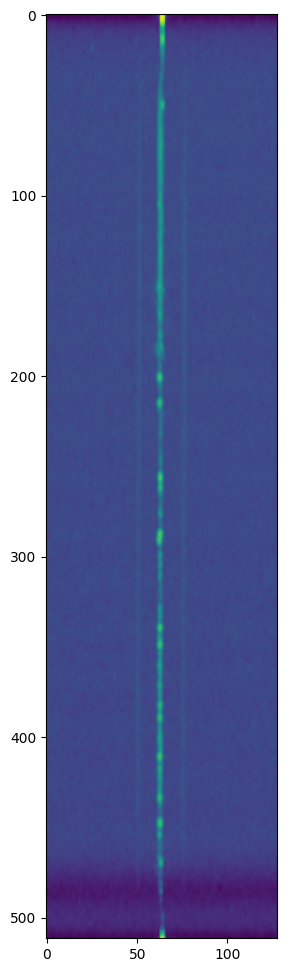

In [4]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

# Path to your .npy file
npy_file = "/home/eorozco/projects/radarObjDet/radarDetector/npyFiles/rd3.npy"  # Change this to your file path

# Load the interleaved radar data
radar = np.load(npy_file)  # shape: (H, W, 384), dtype: float32

print("Radar shape:", radar.shape)
print("Radar dtype:", radar.dtype)

# To reconstruct the original complex data (192 channels):
radar_complex = radar[..., ::2] + 1j * radar[..., 1::2]  # shape: (H, W, 192), dtype: complex64

print("Complex radar shape:", radar_complex.shape)
power_spectrum = np.sum(np.abs(radar_complex),axis=2)
base_image=np.log(power_spectrum)
plt.figure(figsize=(16,12))
plt.imshow(base_image)